Voici un notebook Jupyter qui contient des exemples de modèles de classification pour le jeu de données Fashion MNIST. Les modèles incluent des arbres de décision, des forêts aléatoires, des réseaux de neurones et des réseaux de neurones convolutifs. Les données sont prétraitées et normalisées avant d'être utilisées pour entraîner les modèles. Les performances des modèles sont comparées et évaluées sur les ensembles de données d'entraînement, de validation et de test.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from xgboost import XGBClassifier

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import CategoricalCrossentropy, CategoricalFocalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [6]:
train, test = tf.keras.datasets.fashion_mnist.load_data()

In [7]:
X, y = train
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_test, y_test = test

In [8]:
classes = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# EDA

In [ ]:
X_train.shape

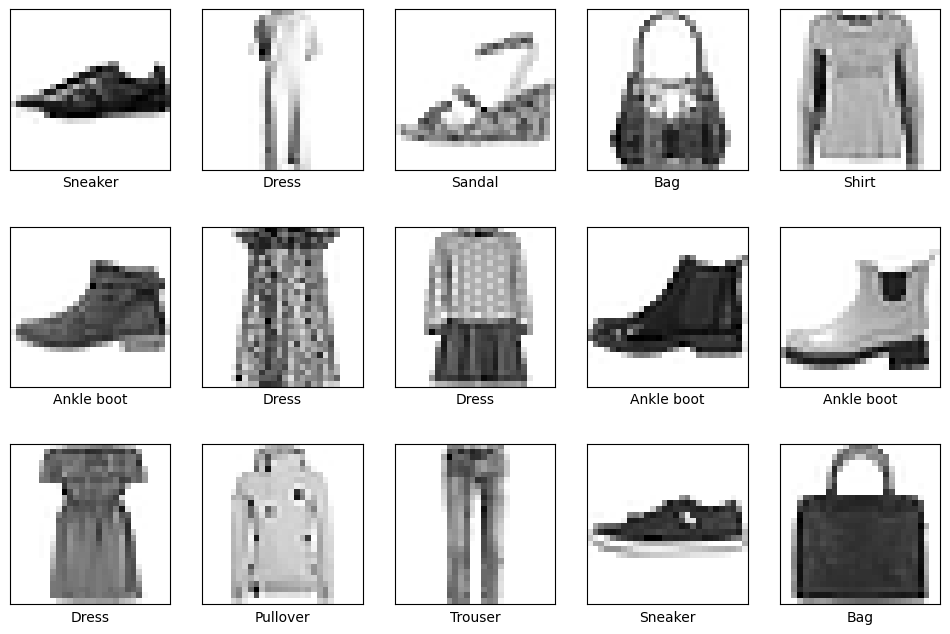

In [9]:
fig, axes = plt.subplots(3, 5, figsize=(12, 8))
for i, ax in enumerate(axes.flat):
    ax.imshow(X_train[i], cmap='binary')
    ax.set_xlabel(classes[y_train[i]])
    ax.set_xticks([])
    ax.set_yticks([])

Text(0.5, 1.0, 'Distribution of the labels in the training set')

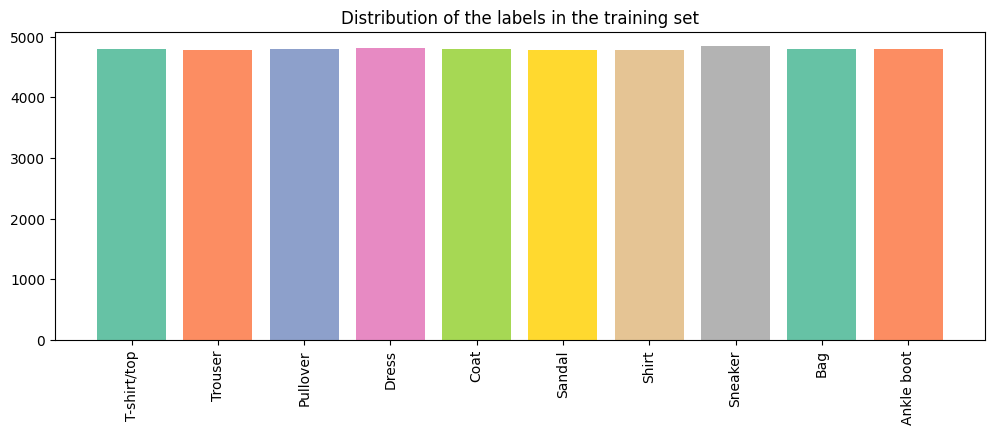

In [10]:
plt.figure(figsize=(12, 4))
plt.bar(
    np.unique(y_train),
    np.bincount(y_train),
    color=plt.cm.Set2.colors
)
plt.xticks(np.unique(y_train), classes, rotation=90)
plt.title('Distribution of the labels in the training set')

La distribution des classes est équirepartie, donc nous n'aurons pas de problèmes de sur/sous-échantillonnage.

Text(0.5, 1.0, 'Histogram of average pixel values per image')

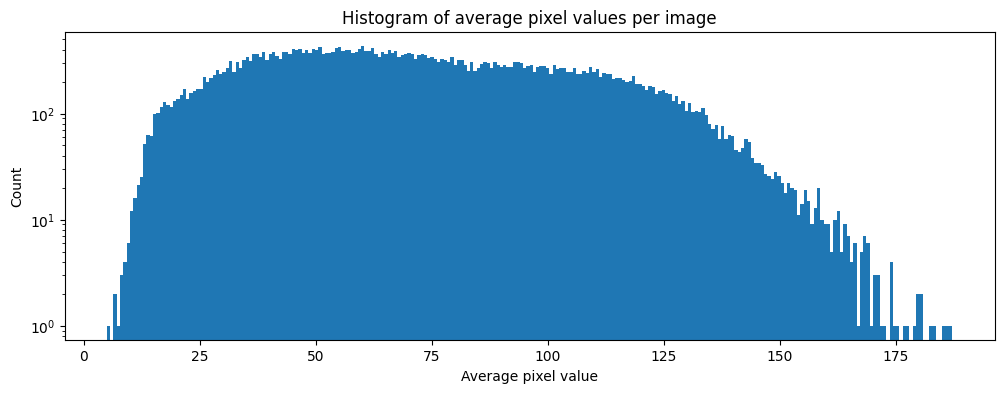

In [11]:
# plot histogram of average intensity per image
plt.figure(figsize=(12, 4))
plt.hist(X_train.mean(axis=(1, 2)), bins=256, log=True)
plt.xlabel('Average pixel value')
plt.ylabel('Count')
plt.title('Histogram of average pixel values per image')

On remarque la distribution des valeurs moyennes des pixels suivent une loi proche de la loi normale

Pour les rendre plus proche de la loi normale on peut utiliser `StandardScaler` ou `MinMaxScaler`

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_val_scaled = scaler.transform(X_val.reshape(-1, 28 * 28)).reshape(-1, 28, 28)
X_test_scaled = scaler.transform(X_test.reshape(-1, 28 * 28)).reshape(-1, 28, 28)

Pour quelques modèles, on a besoin de données 1D (pour les arbres de décision)

In [13]:
X_train_flat = X_train_scaled.reshape(-1, 28 * 28)
X_val_flat = X_val_scaled.reshape(-1, 28 * 28)
X_test_flat = X_test_scaled.reshape(-1, 28 * 28)

On va utiliser la matrice de confusion pour évaluer nos modèles, on crée donc une fonction pour l'afficher

In [14]:
def plot_confusion(y_test, y_pred):
    conf_mat = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(7, 7))
    plt.imshow(conf_mat, cmap='binary')
    plt.xticks(np.arange(10), classes, rotation=90)
    plt.yticks(np.arange(10), classes)
    plt.colorbar()
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion matrix')

# Machine Learning

In [15]:
training_accuracy = {}
validation_accuracy = {}

## Decision Tree

In [16]:
model_dt = DecisionTreeClassifier()
model_dt.fit(X_train_flat, y_train)

DecisionTreeClassifier()

Accuracy training: 1.0
Accuracy validation: 0.79475


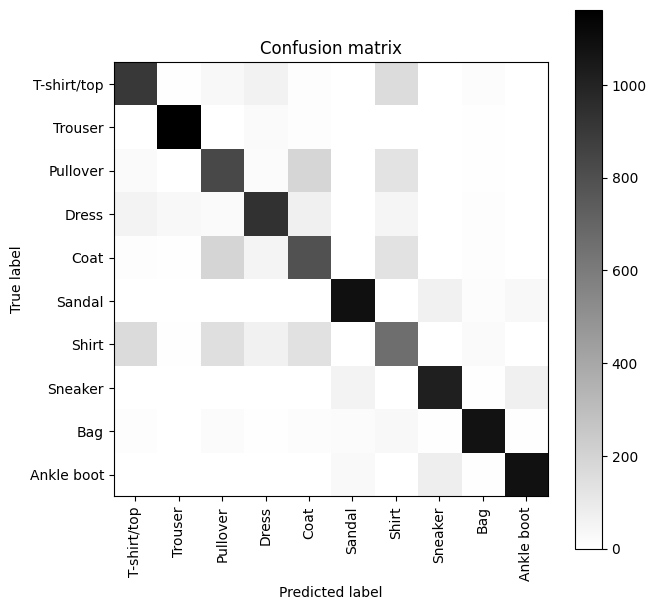

In [17]:
y_train_pred = model_dt.predict(X_train_flat)
y_val_pred = model_dt.predict(X_val_flat)

plot_confusion(y_val, y_val_pred)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

training_accuracy['Decision Tree'] = train_acc
validation_accuracy['Decision Tree'] = val_acc

print('Accuracy training:', train_acc)
print('Accuracy validation:', val_acc)

## Random Forest

In [18]:
model_rf = RandomForestClassifier(n_estimators=100)
model_rf.fit(X_train_flat, y_train)

RandomForestClassifier()

Accuracy training: 1.0
Accuracy validation: 0.88175


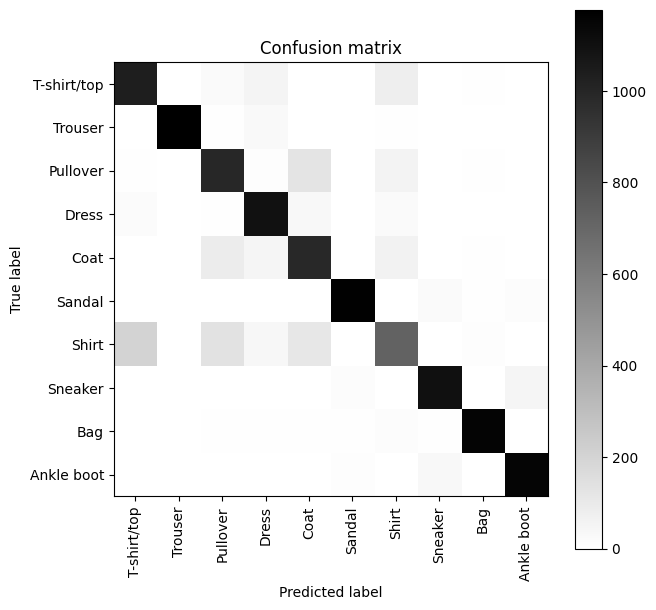

In [19]:
y_train_pred = model_rf.predict(X_train_flat)
y_val_pred = model_rf.predict(X_val_flat)

plot_confusion(y_val, y_val_pred)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

training_accuracy['Random Forest'] = train_acc
validation_accuracy['Random Forest'] = val_acc

print('Accuracy training:', train_acc)
print('Accuracy validation:', val_acc)

## XGBoost

In [20]:
model_xgb = XGBClassifier(n_estimators=100)
model_xgb.fit(X_train_flat, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy training: 0.9999791666666666
Accuracy validation: 0.90425


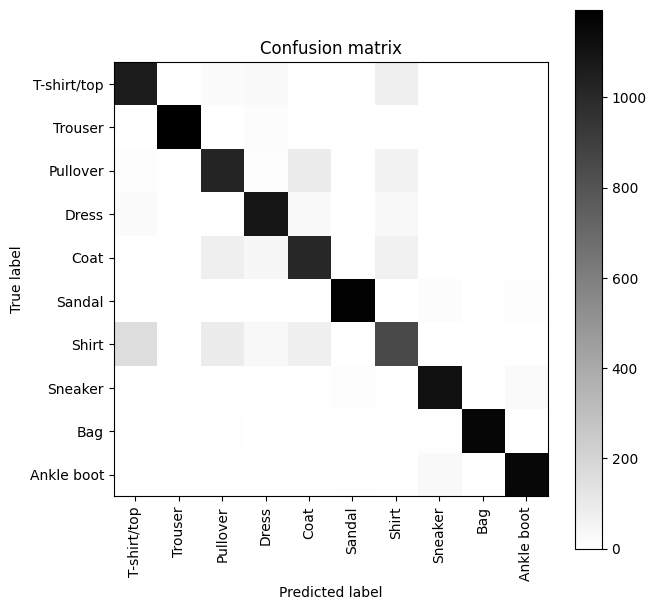

In [21]:
y_train_pred = model_xgb.predict(X_train_flat)
y_val_pred = model_xgb.predict(X_val_flat)

plot_confusion(y_val, y_val_pred)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

training_accuracy['XGBoost'] = train_acc
validation_accuracy['XGBoost'] = val_acc

print('Accuracy training:', train_acc)
print('Accuracy validation:', val_acc)

# Deep Learning

Pour les réseaux de neurones, on doit one-hot-encoder les labels, c'est-à-dire les transformer en vecteurs de 0 et de 1

In [22]:
encoder = OneHotEncoder()
encoder.fit(y.reshape(-1, 1))

y_train_oh = encoder.transform(y_train.reshape(-1, 1)).toarray()
y_val_oh = encoder.transform(y_val.reshape(-1, 1)).toarray()
y_test_oh = encoder.transform(y_test.reshape(-1, 1)).toarray()

## Réseau de neurones

On commence par créer un modèle simple avec quelques couches denses.

On utilise une activation 'linear' pour la couche de sortie car on va utiliser la fonction CategoricalCrossentropy qui attend des logits en entrée

In [23]:
model = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='linear')
])

model.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)   

On utilise EarlyStopping pour éviter le surapprentissage (overfitting).

In [24]:
history = model.fit(
    X_train_flat, y_train_oh,
    validation_data=(X_val_flat, y_val_oh),
    epochs=25,
    batch_size=128,
    callbacks=[
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25


375/375 [==============================] - 2s 3ms/step - loss: 0.4984 - accuracy: 0.8218 - val_loss: 0.3872 - val_accuracy: 0.8602
Epoch 2/25
375/375 [==============================] - 1s 2ms/step - loss: 0.3400 - accuracy: 0.8742 - val_loss: 0.3492 - val_accuracy: 0.8741
Epoch 3/25
375/375 [==============================] - 1s 3ms/step - loss: 0.2990 - accuracy: 0.8889 - val_loss: 0.3387 - val_accuracy: 0.8781
Epoch 4/25
375/375 [==============================] - 1s 2ms/step - loss: 0.2732 - accuracy: 0.9000 - val_loss: 0.3453 - val_accuracy: 0.8795
Epoch 5/25
375/375 [==============================] - 1s 2ms/step - loss: 0.2466 - accuracy: 0.9076 - val_loss: 0.3264 - val_accuracy: 0.8867
Epoch 6/25
375/375 [==============================] - 1s 2ms/step - loss: 0.2296 - accuracy: 0.9146 - val_loss: 0.3416 - val_accuracy: 0.8848
Epoch 7/25
375/375 [==============================] - 1s 2ms/step - loss: 0.2158 - accuracy: 0.9191 - val_loss: 0.3310 - val_accuracy: 0.8844
Epoch 8/25
375/37

Text(0.5, 1.0, 'Accuracy over training epochs')

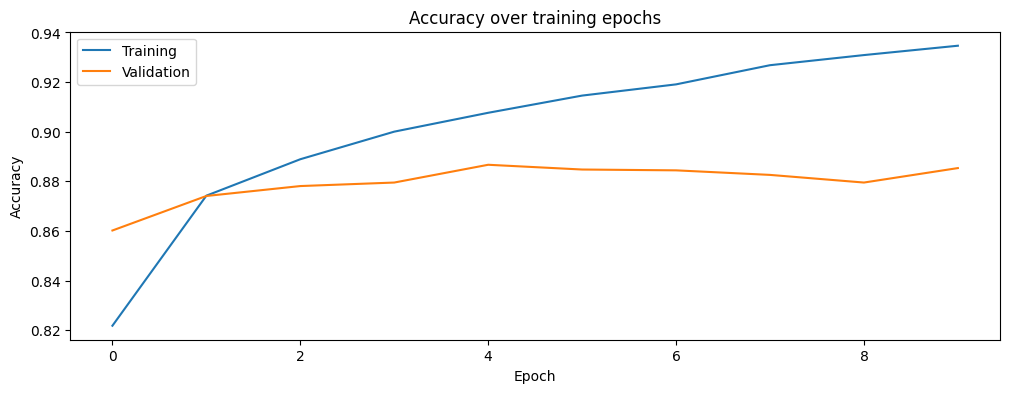

In [25]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over training epochs')

375/375 [==============================] - 0s 1ms/step
Accuracy training: 0.9217083333333334
Accuracy validation: 0.8866666666666667


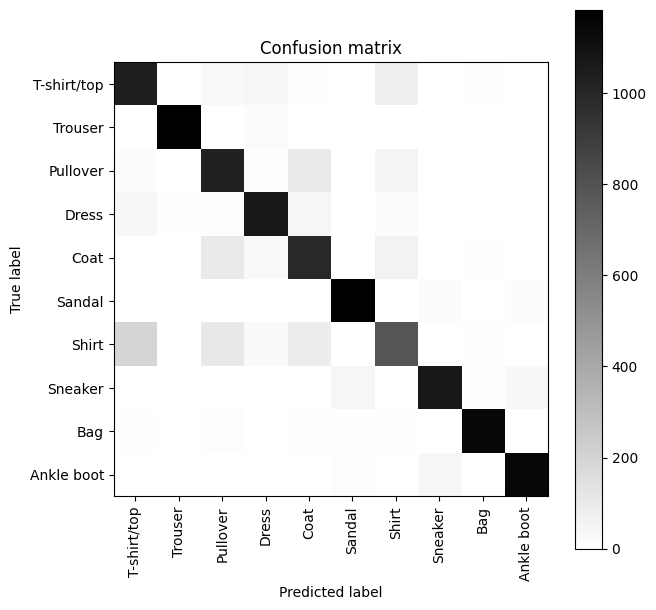

In [26]:
y_train_pred_oh = model.predict(X_train_flat)
y_val_pred_oh = model.predict(X_val_flat)

y_train_pred = encoder.inverse_transform(y_train_pred_oh)
y_val_pred = encoder.inverse_transform(y_val_pred_oh)

plot_confusion(y_val, y_val_pred)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

training_accuracy['Neural Network'] = train_acc
validation_accuracy['Neural Network'] = val_acc

print('Accuracy training:', train_acc)
print('Accuracy validation:', val_acc)

On remaque que le modèle commence à overfitter, on va donc ajouter du dropout pour régulariser le modèle

## Réseau de neurones (Dropout)

In [27]:
model_2 = Sequential([
    Dense(128, activation='relu', input_shape=(784,)),
    BatchNormalization(),
    Dropout(0.2),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.2),
    Dense(10, activation='linear')
])

model_2.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)   

In [28]:
history = model_2.fit(
    X_train_flat, y_train_oh,
    validation_data=(X_val_flat, y_val_oh),
    epochs=25,
    batch_size=128,
    callbacks=[
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25


375/375 [==============================] - 2s 4ms/step - loss: 0.7142 - accuracy: 0.7633 - val_loss: 0.4289 - val_accuracy: 0.8435
Epoch 2/25
375/375 [==============================] - 1s 3ms/step - loss: 0.4653 - accuracy: 0.8378 - val_loss: 0.3783 - val_accuracy: 0.8654
Epoch 3/25
375/375 [==============================] - 1s 3ms/step - loss: 0.4141 - accuracy: 0.8538 - val_loss: 0.3634 - val_accuracy: 0.8699
Epoch 4/25
375/375 [==============================] - 1s 3ms/step - loss: 0.3898 - accuracy: 0.8624 - val_loss: 0.3447 - val_accuracy: 0.8740
Epoch 5/25
375/375 [==============================] - 1s 3ms/step - loss: 0.3646 - accuracy: 0.8721 - val_loss: 0.3375 - val_accuracy: 0.8781
Epoch 6/25
375/375 [==============================] - 1s 3ms/step - loss: 0.3499 - accuracy: 0.8754 - val_loss: 0.3277 - val_accuracy: 0.8835
Epoch 7/25
375/375 [==============================] - 1s 3ms/step - loss: 0.3379 - accuracy: 0.8795 - val_loss: 0.3259 - val_accuracy: 0.8809
Epoch 8/25
375/37

Text(0.5, 1.0, 'Accuracy over training epochs')

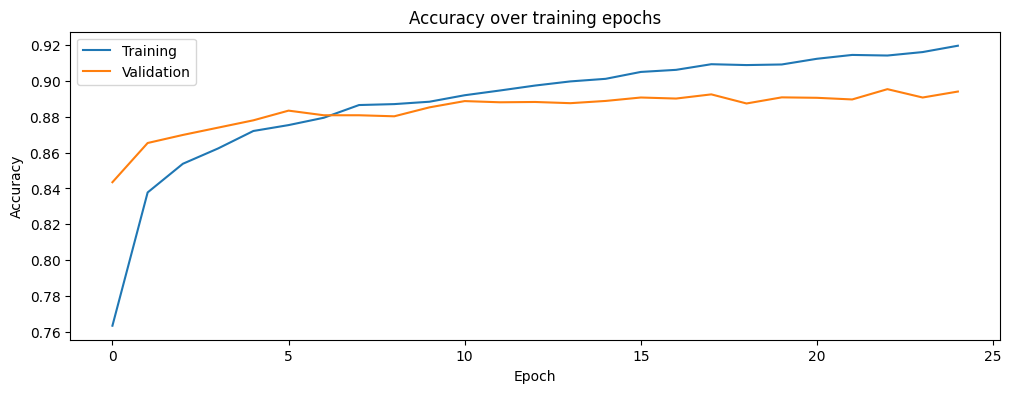

In [29]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over training epochs')

 105/1500 [=>............................] - ETA: 1s

375/375 [==============================] - 0s 1ms/step
Accuracy training: 0.9451666666666667
Accuracy validation: 0.8941666666666667


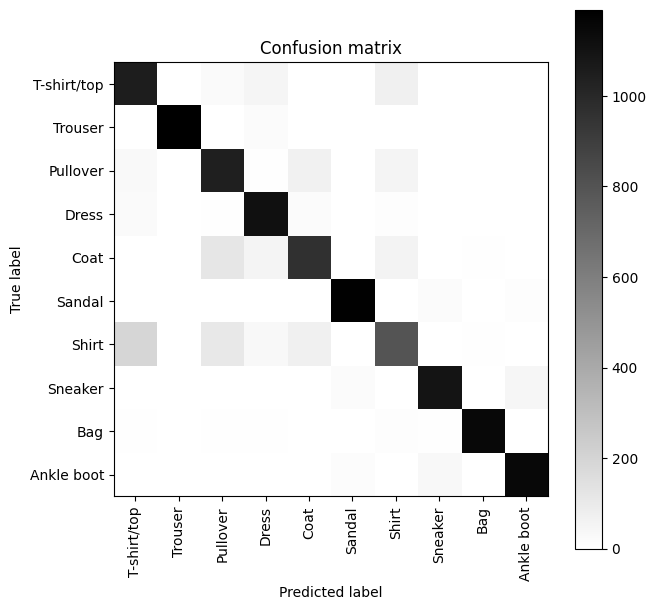

In [30]:
y_train_pred_oh = model_2.predict(X_train_flat)
y_val_pred_oh = model_2.predict(X_val_flat)

y_train_pred = encoder.inverse_transform(y_train_pred_oh)
y_val_pred = encoder.inverse_transform(y_val_pred_oh)

plot_confusion(y_val, y_val_pred)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

training_accuracy['Neural Network (Dropout)'] = train_acc
validation_accuracy['Neural Network (Dropout)'] = val_acc

print('Accuracy training:', train_acc)
print('Accuracy validation:', val_acc)

Dans ce cas, on a réussi à améliorer la performance du modèle en ajoutant du dropout et de la normalisation.

## CNN 1D

Un réseau de neurones convolutif est un réseau de neurones qui utilise des couches de convolution.

Ceci est utile pour les données d'images car les pixels voisins sont souvent corrélés.

In [31]:
model_3 = Sequential([
    Conv1D(32, 3, activation='relu', input_shape=(784, 1)),
    MaxPooling1D(2),

    Conv1D(64, 3, activation='relu'),
    MaxPooling1D(2),

    Conv1D(128, 3, activation='relu'),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='linear')
])

model_3.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [32]:
model_3.fit(
    X_train_flat.reshape(-1, 784, 1), y_train_oh,
    validation_data=(X_val_flat.reshape(-1, 784, 1), y_val_oh),
    epochs=25,
    batch_size=128,
    callbacks=[
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25


375/375 [==============================] - 41s 108ms/step - loss: 0.4744 - accuracy: 0.8303 - val_loss: 0.3304 - val_accuracy: 0.8801
Epoch 2/25
375/375 [==============================] - 39s 104ms/step - loss: 0.2899 - accuracy: 0.8945 - val_loss: 0.3185 - val_accuracy: 0.8872
Epoch 3/25
375/375 [==============================] - 41s 109ms/step - loss: 0.2382 - accuracy: 0.9129 - val_loss: 0.2771 - val_accuracy: 0.9030
Epoch 4/25
375/375 [==============================] - 39s 105ms/step - loss: 0.2028 - accuracy: 0.9269 - val_loss: 0.2733 - val_accuracy: 0.9006
Epoch 5/25
375/375 [==============================] - 40s 106ms/step - loss: 0.1659 - accuracy: 0.9383 - val_loss: 0.2759 - val_accuracy: 0.9041
Epoch 6/25
375/375 [==============================] - 40s 106ms/step - loss: 0.1396 - accuracy: 0.9486 - val_loss: 0.2790 - val_accuracy: 0.9071
Epoch 7/25
375/375 [==============================] - 38s 102ms/step - loss: 0.1108 - accuracy: 0.9583 - val_loss: 0.2931 - val_accuracy: 0.9

375/375 [==============================] - 3s 7ms/step
Accuracy training: 0.9796458333333333
Accuracy validation: 0.90925


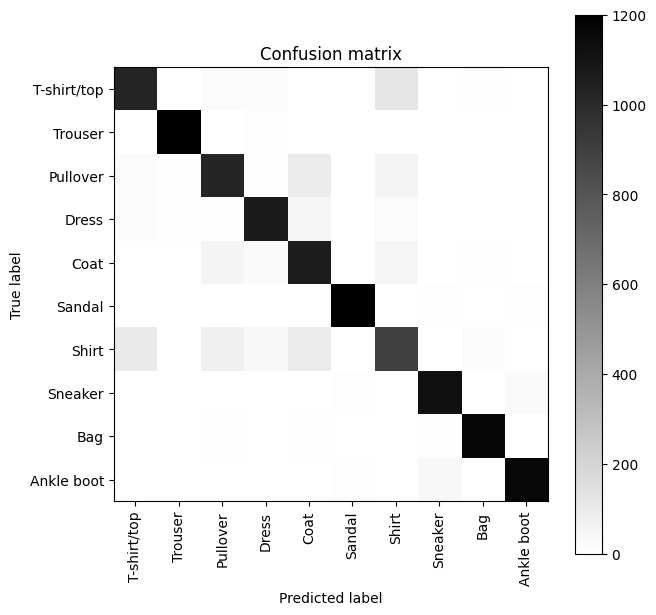

In [33]:
y_train_pred_oh = model_3.predict(X_train_flat)
y_val_pred_oh = model_3.predict(X_val_flat)

y_train_pred = encoder.inverse_transform(y_train_pred_oh)
y_val_pred = encoder.inverse_transform(y_val_pred_oh)

plot_confusion(y_val, y_val_pred)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

training_accuracy['CNN 1D'] = train_acc
validation_accuracy['CNN 1D'] = val_acc

print('Accuracy training:', train_acc)
print('Accuracy validation:', val_acc)

## Model 4

On refait le même modèle mais avec des neurones en 2D

On reshape les données pour qu'elles soient en 2D

In [34]:
model_4 = Sequential([
    Conv2D(32, (5, 5), activation='relu', input_shape=(28, 28, 1), padding='same'),
    MaxPooling2D((2, 2)),

    Conv2D(64, (5, 5), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (5, 5), activation='relu'),

    Flatten(),

    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(10, activation='linear')
])

model_4.compile(
    optimizer='adam',
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [35]:
model_4.fit(
    X_train.reshape(-1, 28, 28, 1), y_train_oh,
    validation_data=(X_val.reshape(-1, 28, 28, 1), y_val_oh),
    epochs=25,
    batch_size=128,
    callbacks=[
        EarlyStopping(
            monitor='val_accuracy',
            patience=5,
            restore_best_weights=True
        )
    ]
)

Epoch 1/25


375/375 [==============================] - 22s 57ms/step - loss: 0.6746 - accuracy: 0.7843 - val_loss: 0.3989 - val_accuracy: 0.8560
Epoch 2/25
375/375 [==============================] - 22s 60ms/step - loss: 0.3373 - accuracy: 0.8769 - val_loss: 0.3396 - val_accuracy: 0.8801
Epoch 3/25
375/375 [==============================] - 22s 57ms/step - loss: 0.2874 - accuracy: 0.8955 - val_loss: 0.3092 - val_accuracy: 0.8880
Epoch 4/25
375/375 [==============================] - 21s 56ms/step - loss: 0.2594 - accuracy: 0.9064 - val_loss: 0.2931 - val_accuracy: 0.8947
Epoch 5/25
375/375 [==============================] - 21s 57ms/step - loss: 0.2413 - accuracy: 0.9118 - val_loss: 0.2899 - val_accuracy: 0.8973
Epoch 6/25
375/375 [==============================] - 21s 56ms/step - loss: 0.2216 - accuracy: 0.9183 - val_loss: 0.2634 - val_accuracy: 0.9051
Epoch 7/25
375/375 [==============================] - 21s 56ms/step - loss: 0.2088 - accuracy: 0.9230 - val_loss: 0.2925 - val_accuracy: 0.8988
Epo

Text(0.5, 1.0, 'Accuracy over training epochs')

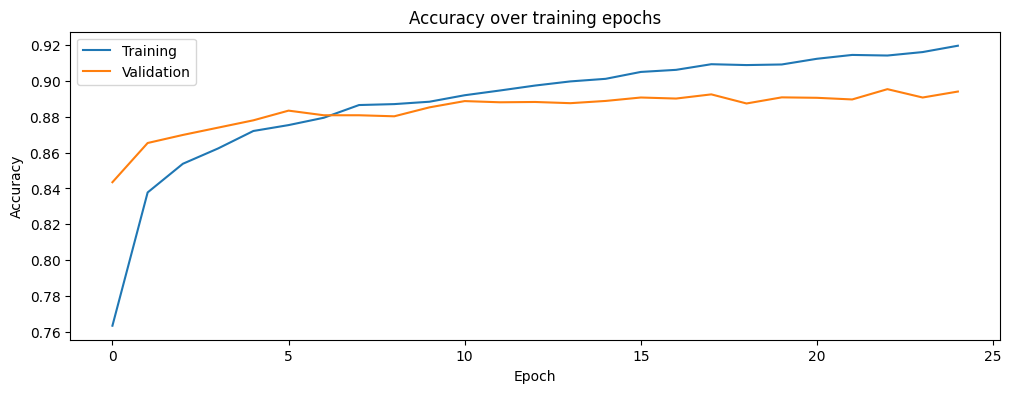

In [36]:
plt.figure(figsize=(12, 4))
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over training epochs')

  14/1500 [..............................] - ETA: 12s

375/375 [==============================] - 2s 5ms/step
Accuracy training: 0.9694375
Accuracy validation: 0.91025


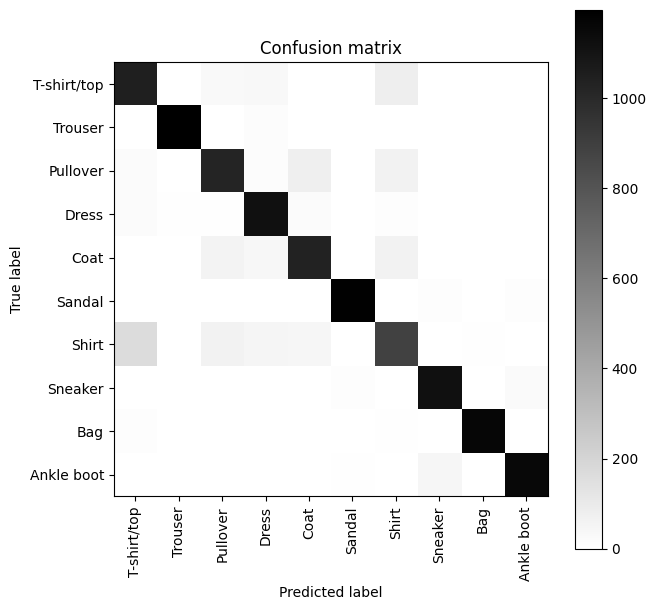

In [39]:
y_train_pred_oh = model_4.predict(X_train)
y_val_pred_oh = model_4.predict(X_val)

y_train_pred = encoder.inverse_transform(y_train_pred_oh)
y_val_pred = encoder.inverse_transform(y_val_pred_oh)

plot_confusion(y_val, y_val_pred)

train_acc = accuracy_score(y_train, y_train_pred)
val_acc = accuracy_score(y_val, y_val_pred)

training_accuracy['CNN 2D'] = train_acc
validation_accuracy['CNN 2D'] = val_acc

print('Accuracy training:', train_acc)
print('Accuracy validation:', val_acc)

# Comparaison des modeles

Text(0.5, 1.0, 'Accuracy of the models on the training and validation set')

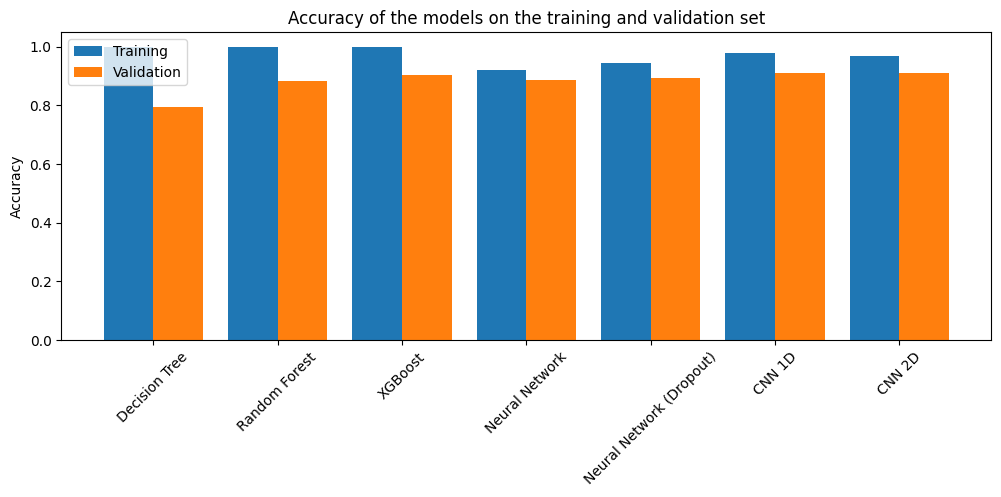

In [40]:
models = training_accuracy.keys()

plt.figure(figsize=(12, 4))

plt.bar(
    np.arange(len(models)) - 0.2,
    training_accuracy.values(),
    width=0.4,
    label='Training'
)

plt.bar(
    np.arange(len(models)) + 0.2,
    validation_accuracy.values(),
    width=0.4,
    label='Validation'
)

plt.xticks(np.arange(len(models)), models, rotation=45)
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy of the models on the training and validation set')

On compare les résultats obtenus avec les différents modèles

On remarque que les modèles de réseaux de neurones sont les plus performants

On va evaluer le modèle sur le test set

 49/313 [===>..........................] - ETA: 0s 

313/313 [==============================] - 0s 1ms/step
Accuracy test: 0.8847


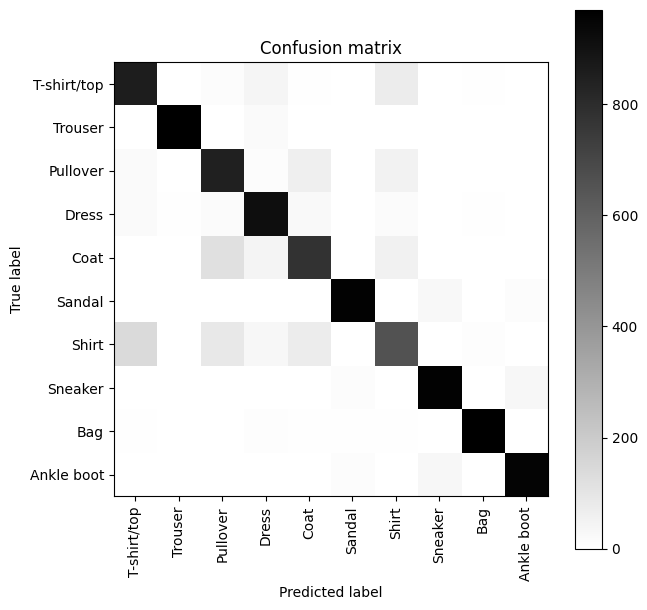

In [41]:
best_model = model_2

y_test_pred_oh = best_model.predict(X_test_flat)
y_test_pred = encoder.inverse_transform(y_test_pred_oh)

plot_confusion(y_test, y_test_pred)

print('Accuracy test:', accuracy_score(y_test, y_test_pred))